In [1]:
import ee
import datetime
import os
import itertools
import sys
import collections

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

# append module folter path into sys-path so wen can import necessary modules
sys.path.append('../Process_1_GEE_Python_Classification/')

In [3]:
from BackGround_modules.Class_6_Extract_Original_and_Fourier_Fitted_Image_Value_Series import Restore_Fourier_Fitting

##### Get the untouched validation points

In [4]:
# import the untouched samples by specify a 101 random state and a 0.25 threshold
sample_pt_2016 = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019")\
                   .randomColumn('split', 101)\
                   .filterMetadata('split','less_than',0.25)

In [5]:
# get the built/non-built points
built_pt     = sample_pt_2016.filterMetadata('Built','equals',1)
non_built_pt = sample_pt_2016.filterMetadata('Built','equals',0)

##### get the fittend values

In [6]:
# define basic parameters
Normalized_Index = ['NDVI','NDBI','EVI']
year_name  = [f'{i}_{i+2}' for i in range(1990,2020,3)]
start_date = '2017-01-01'

Get the independents to restore the fitted Fourier series

In [7]:
independents = {}

# set a list to store t
date_list = ee.List.sequence(0,365.25 * 3,16)
date_list = date_list.map(lambda x: ee.Date(start_date).advance(x,'day'))    

# put the data to independents
time_stamp = date_list.map(lambda x :ee.Date(x).format()).getInfo()
independents.update({'time':[i[:10] for i in time_stamp]})

# Compute time in fractional years since the epoch.
years = date_list.map(lambda x: ee.Date(x)\
                                   .difference(ee.Date('1970-01-01'), 'year')\
                                   .multiply(2*3.1415926)).getInfo()
# add t to independents
independents['t'] = np.array(years)


# get other derivative time independents
for i in range(1,4):

    # Get the cosine terms.
    cos = {f'cos_{i}': np.cos(np.array(years) * np.array(i))}
    # Get the sin terms.
    sin = {f'sin_{i}': np.sin(np.array(years) * np.array(i))}

    # add cos and sin bands to image
    independents.update(cos)
    independents.update(sin)

# add constant to independents
independents.update({'constant':1})

# pack the independents into a datafram
independents = pd.DataFrame(independents)

Extract Fourier_img value to sample_pts

In [8]:
# import Fourier img   
Fourier_img = [ee.Image(f"users/Jinzhu_Deakin/North_China_Plain/Fourier_img_harmonic_3/Fourier_img_{year}_harmonic_3")\
               for year in year_name[:5]] + \
              [ee.Image(f"users/wang8052664/North_China_Plain/Fourier_imgs/Fourier_img_{year}_harmonic_3")\
               for year in year_name[5:]] 

In [9]:
# extract the Fourier values use sampleReions
built_fourier    =  Fourier_img[-1].sampleRegions(collection = built_pt, 
                                             properties = ['Built'], 
                                             scale = 30, 
                                             tileScale = 1 )

non_built_fourier = Fourier_img[-1].sampleRegions(collection = non_built_pt, 
                                             properties = ['Built'], 
                                             scale = 30, 
                                             tileScale = 1 )

In [10]:
# fetch the Fourier values
built_fourier_original = built_fourier.getInfo()
built_fourier_df = pd.DataFrame([i['properties'] for i in  built_fourier_original['features']])

non_built_fourier_original = non_built_fourier.getInfo()
non_built_fourier_df = pd.DataFrame([i['properties'] for i in  non_built_fourier_original['features']])

Compute the fitted values

In [11]:
independents_idx = [f'cos_{i}' for i in range(1,4)] \
                 + [f'sin_{i}' for i in range(1,4)] \
                 + ['constant','t']

In [17]:
fitted_df_list = []

for idx in Normalized_Index:
    
    # create the dependents idx according to the order of independents_idx
    dependent_idx = [f'{idx}_{s}' for s in independents_idx]
    
    # get independents
    X = independents[independents_idx].values
    
    # get built Fourier values, here divide by 1000 because the Fourier img was mutilplied 
    # by 1000 during exporting
    y_built =     built_fourier_df[dependent_idx].T.values/1000
    fitted_built = X@y_built
    
    # get built Fourier values, here divide by 1000 because the Fourier img was mutilplied 
    # by 1000 during exporting
    y_non_built = non_built_fourier_df[dependent_idx].T.values/1000
    fitted_non_built = X@y_non_built
    
    # put the fitted value into a dataframe
    df_bulit     = pd.DataFrame(fitted_built)
    df_non_bulit = pd.DataFrame(fitted_non_built)
    
    # add attributes to df
    df_bulit['Type']  = 'Built'
    df_bulit['Index'] = idx
    df_bulit['Date']  = independents['time']
    
    df_non_bulit['Type']  = 'Non Built'
    df_non_bulit['Index'] = idx
    df_non_bulit['Date']  = independents['time']
    
    # add fitted df to fitted_df_list
    fitted_df_list.append(df_bulit)
    fitted_df_list.append(df_non_bulit)

##### Convert the restored result into a dataframe

In [12]:
# # concat all dfs
# fitted_df = pd.concat(fitted_df_list)
# fitted_df.set_index(['Date','Type','Index'],inplace=True)

# # stack the df to a long format
# fitted_df_long = pd.DataFrame(fitted_df.stack()).reset_index()
# fitted_df_long.columns = ['Date','Type','Index','pt','value']

# # save to disk
# fitted_df_long.to_csv('./Result/Fitted_values.csv',index=False)

##### Get the original values

In [13]:
# get the built/non-built points
built_pt     = sample_pt_2016.filterMetadata('Built','equals',1)
non_built_pt = sample_pt_2016.filterMetadata('Built','equals',0)

In [14]:
# fetch the pt value
built_list     = built_pt.toList(sample_pt_2016.size()).getInfo()
non_built_list = non_built_pt.toList(sample_pt_2016.size()).getInfo()

In [15]:
# get the coordinates
built_coor     = [i['geometry']['coordinates'] for i in built_list]
non_built_coor = [i['geometry']['coordinates'] for i in non_built_list]

In [28]:
original_df_list = []


pt_num = 0
total_len = len(list(zip(built_coor,non_built_coor)))

for bt,nbt in list(zip(built_coor,non_built_coor)):

    
    # create a Restore_instance
    restore_instance_bt  = Restore_Fourier_Fitting(point=bt,get_fitted_val=False)
    restore_instance_nbt = Restore_Fourier_Fitting(point=nbt,get_fitted_val=False)
    
    # get the original value
    restore_instance_bt.Get_Original_and_Fitting_df()
    restore_instance_nbt.Get_Original_and_Fitting_df()
    
    # get the original_df
    original_df_bt  = restore_instance_bt.original_df
    original_df_nbt = restore_instance_nbt.original_df
    
    # add attributes to original_df
    original_df_bt['Type']  = 'Built'
    original_df_nbt['Type'] = 'Non Built'
    
    original_df_bt['pt']  = pt_num
    original_df_nbt['pt'] = pt_num
    
    # add the original_df to list
    original_df_list.append(original_df_bt)
    original_df_list.append(original_df_nbt)
    
    # print out the process
    pt_num = pt_num +1
    
    print()
    print('=======================================================')
    print(f'Get original values of {pt_num}/{total_len} finished!')
    print('=======================================================')
    print()

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 667/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 668/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 681/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 682/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 695/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 696/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 710/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 711/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 724/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 725/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 738/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 739/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 753/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 754/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 767/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 768/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 781/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 782/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 796/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 797/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 810/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 811/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 824/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 825/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 839/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 840/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 853/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 854/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 867/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 868/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 882/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 883/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 896/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 897/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 910/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 911/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 925/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 926/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 939/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 940/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 953/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 954/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 968/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 969/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==

3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 982/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Computation Skipped!

Get original values of 983/990 finished!

Analyzing the images of 2017_2019
Analyzing the images of 2017_2019
1/5 ==> Fourier Transformation Finished!
2/5 ==> Original Image Value df Acquired!
3/5 ==> Independents Values Computation Completed!
5/5 ==> Fitted Value Co

In [29]:
# # format and save to disk
# original_values = pd.concat(original_df_list)

# # convert the df to long format
# original_long = pd.DataFrame(original_values.set_index(['time','Type','pt']).stack())
# original_long.reset_index(inplace = True)
# original_long.columns = ['time','Type','pt','Index','value']

# # save to dis
# original_long.to_csv('./Result/Original_value.csv',index=False)

##### Make plots

In [36]:
# read csv
original_long_df = pd.read_csv('./Result/Original_value.csv')
fitted_long_df   = pd.read_csv('./Result/Fitted_values.csv')

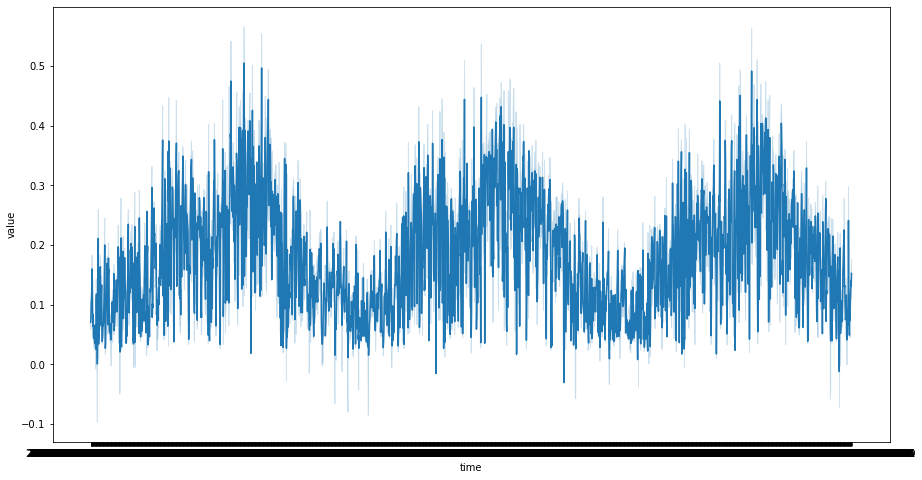

In [38]:
plt.figure(figsize=(15,8))
sns.lineplot(data = original_long_df[(original_long_df['Type'] == 'Built')&
                                     (original_long_df['Index'] == 'NDVI')], 
             x = 'time', 
             y = 'value')

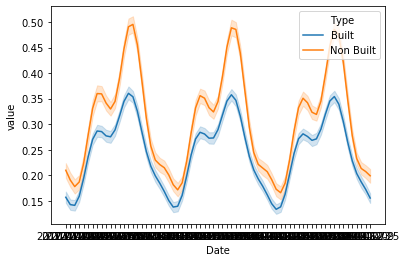

In [21]:
plt.figure(figsize=(15,8))
sns.lineplot(data = fitted_long_df[fitted_long_df['Index'] == 'NDVI'], 
             x = 'Date', 
             y = 'value',
             hue='Type')